# Reproducing Figure 4 from Gal and Ghahramani (2016)

This notebook reproduces Figure 4 from the paper:

**Dropout as a Bayesian Approximation: Representing Model Uncertainty in Deep Learning**  
Yarin Gal and Zoubin Ghahramani, ICML 2016  
[arXiv:1506.02142](https://arxiv.org/abs/1506.02142)


In [62]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from keras.datasets import mnist
from torch.utils.data import TensorDataset, DataLoader
import torch
import os
import ssl
import certifi

In [63]:
class LeNetDropout(nn.Module):
    def __init__(self, dropout_p=0.5):
        super(LeNetDropout, self).__init__()
        self.conv1 = nn.Conv2d(1, 20, 5, 1)
        self.conv2 = nn.Conv2d(20, 50, 5, 1)
        self.fc1 = nn.Linear(4*4*50, 500)
        self.dropout = nn.Dropout(p=dropout_p)
        self.fc2 = nn.Linear(500, 10)
    
    def forward(self, x):
        x = F.relu(self.conv1(x))          
        x = F.max_pool2d(x, 2, 2)         
        x = F.relu(self.conv2(x))           
        x = F.max_pool2d(x, 2, 2)           
        x = x.view(-1, 4*4*50)
        x = F.relu(self.fc1(x))
        x = self.dropout(x) # dropout before final layer
        x = self.fc2(x)
        return x

In [64]:

os.environ['SSL_CERT_FILE'] = certifi.where()
ssl._create_default_https_context = ssl._create_unverified_context  # optional fallback

ssl_context = ssl.create_default_context(cafile=certifi.where())
# Load MNIST using keras
(X_train, y_train), (X_test, y_test) = mnist.load_data()
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])
# normalize and convert to float tensors
X_train = torch.tensor(X_train / 255.0, dtype=torch.float32).unsqueeze(1)  # shape: (n_samples, 1, 28, 28)
X_test = torch.tensor(X_test / 255.0, dtype=torch.float32).unsqueeze(1)
y_train = torch.tensor(y_train, dtype=torch.long)
y_test = torch.tensor(y_test, dtype=torch.long)

train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1000, shuffle=False)

In [65]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = LeNetDropout(dropout_p=0.5).to(device)

optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)
criterion = nn.CrossEntropyLoss()

def train(model, loader, epochs=5):
    model.train()
    for epoch in range(epochs):
        for images, labels in tqdm(loader):
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

train(model, train_loader, epochs=5)

100%|██████████| 938/938 [00:12<00:00, 77.72it/s]


In [120]:
from torchvision.transforms import functional as TF

# get a digit-1 image
digit_1_images = [img for img, label in test_dataset if label == 1]
digit_img = digit_1_images[0]

# generate rotated versions 
angles = list(range(30, 90, 5))
rotated_images = [TF.rotate(digit_img, angle) for angle in angles]
rotated_tensor = torch.stack(rotated_images) 
rotated_tensor = rotated_tensor.to(device)

In [136]:
def mc_predictions(model, inputs, T=1000):
    model.train()
    softmax_inputs = []
    softmax_outputs = []
    
    for _ in range(T):
        with torch.no_grad():
            logits = model(inputs)
            softmax_inputs.append(logits.cpu().numpy())
            softmax_outputs.append(F.softmax(logits, dim=1).cpu().numpy())
    
    return np.stack(softmax_inputs), np.stack(softmax_outputs)

logits_mc, probs_mc = mc_predictions(model, rotated_tensor, T=1000)

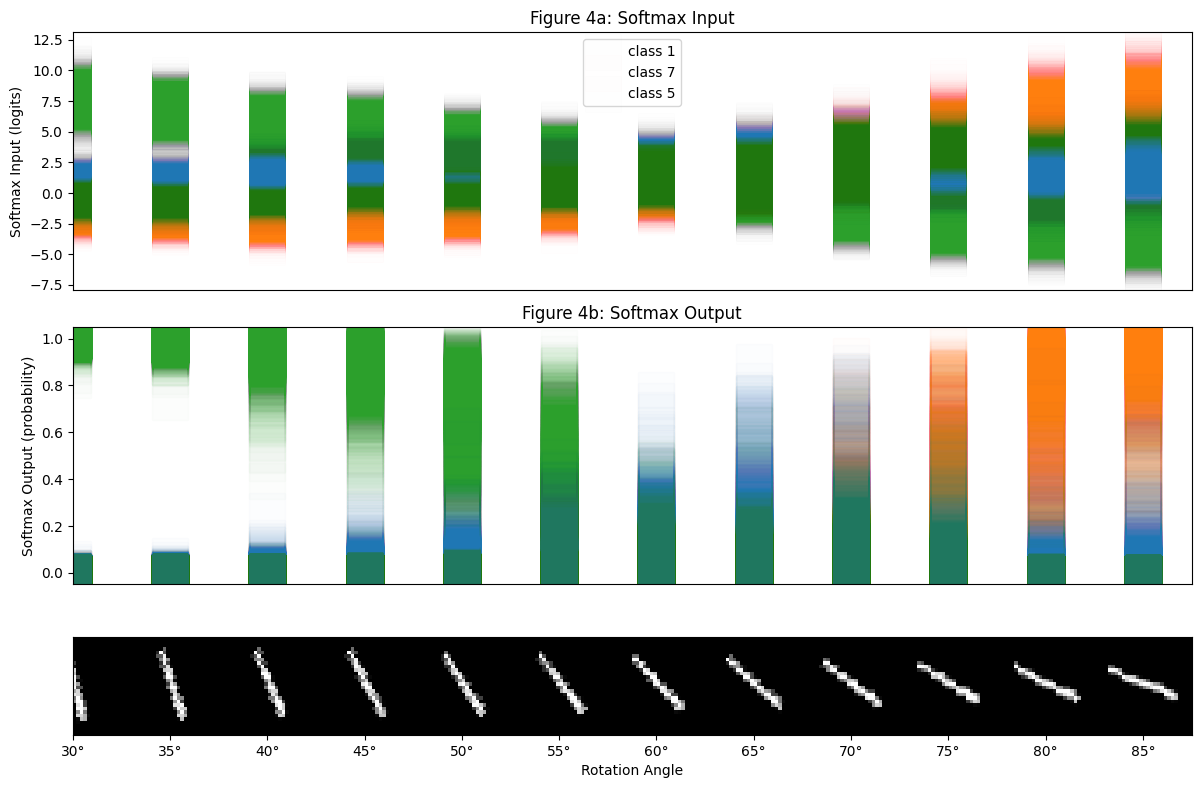

In [138]:

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 8), gridspec_kw={'height_ratios': [2, 2, 1]}, sharex=True)

top_classes = [1, 7, 5]
marker_shape = 's'
class_colors = {1: 'tab:green', 7: 'tab:orange', 5: 'tab:blue'}

for i in range(len(angles)):
    logits_i = logits_mc[:, i, :]
    probs_i = probs_mc[:, i, :]
    
    for cls in top_classes:
        ax1.scatter(
            [i] * logits_i.shape[0], logits_i[:, cls],
            alpha=0.005, s=700,
            label=f'class {cls}' if i == 0 else "",
            marker=marker_shape,
            color=class_colors[cls]
        )
        ax2.scatter(
            [i] * probs_i.shape[0], probs_i[:, cls],
            alpha=0.01, s=700,
            label=f'class {cls}' if i == 0 else "",
            marker=marker_shape,
            color=class_colors[cls]
        )

# plot the rotated digit "1" images below
for i, img in enumerate(rotated_images):
    ax3.imshow(img.squeeze(), cmap='gray', extent=(i - 0.5, i + 0.5, 0, 1))

ax3.set_ylim(0, 1)
ax3.set_yticks([])
ax3.set_xticks(range(len(angles)))
ax3.set_xticklabels([f"{angle}°" for angle in angles])
ax3.set_xlabel("Rotation Angle")


ax1.set_ylabel("Softmax Input (logits)")
ax2.set_ylabel("Softmax Output (probability)")
ax1.set_title("Figure 4a: Softmax Input")
ax2.set_title("Figure 4b: Softmax Output")

ax1.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax2.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)


handles, labels = ax1.get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax1.legend(by_label.values(), by_label.keys())

plt.tight_layout()
plt.show()